# 15. GraphRAG - Graph-based Knowledge Retrieval

**Complexity:** ⭐⭐⭐⭐⭐

## Overview

**GraphRAG** (Microsoft Research) is a revolutionary approach that represents knowledge as a graph instead of vectors, enabling:
- Multi-hop reasoning across relationships
- Entity-centric retrieval
- Community-based summarization
- Relationship-aware context

### The Problem

Traditional vector RAG struggles with:
- **Multi-hop questions**: "Who worked with someone who collaborated with Einstein?"
- **Relationship queries**: "What's the connection between X and Y?"
- **Entity disambiguation**: Same name, different entities
- **Structural knowledge**: Understanding how concepts relate

### The Solution

GraphRAG builds a **knowledge graph**:
```
[Entity] --relationship--> [Entity]
```

**Example:**
```
LangChain --created_by--> Harrison Chase
LangChain --includes--> LCEL
LCEL --is_a--> Framework Component
LCEL --enables--> Chain Building
```

### Pipeline

```
Documents → Entity Extraction → Relationship Extraction
    → Graph Construction → Community Detection
    → Graph Indexing → Query Processing
    → Graph Traversal → Answer Generation
```

### Key Concepts

1. **Entities**: People, organizations, concepts, technologies
2. **Relationships**: How entities connect
3. **Communities**: Clusters of related entities
4. **Multi-hop**: Following paths through graph
5. **Subgraph**: Relevant portion of full graph

### Microsoft GraphRAG Features

- **Global queries**: Use community summaries
- **Local queries**: Traverse from specific entities
- **Hierarchical communities**: Multi-level clustering
- **Embeddings**: Vector representation of graph nodes

### When to Use

✅ **Good for:**
- Complex knowledge domains
- Multi-hop reasoning
- Relationship-heavy content
- Entity-centric queries
- Knowledge exploration

❌ **Not ideal for:**
- Simple document retrieval
- Real-time applications (slow indexing)
- Unstructured narrative text
- When relationships aren't explicit

### Trade-offs

**Pros:**
- ✅ Best for multi-hop reasoning
- ✅ Understands relationships
- ✅ Handles complex queries
- ✅ Explainable paths

**Cons:**
- ❌ Very slow indexing (entity + relationship extraction)
- ❌ High LLM costs (many extraction calls)
- ❌ Complex implementation
- ❌ Graph storage overhead

---

## Implementation

We'll build a simplified GraphRAG system with all core components.

## 1. Setup and Imports

In [1]:
import sys
import json
import time
from pathlib import Path
from typing import List, Dict, Any
from collections import defaultdict

# Add parent directory to path for imports
sys.path.append(str(Path("../..").resolve()))

import networkx as nx
import matplotlib.pyplot as plt
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_community.vectorstores import FAISS

from shared.config import (
    verify_api_key,
    DEFAULT_MODEL,
    DEFAULT_TEMPERATURE,
    OPENAI_EMBEDDING_MODEL,
    VECTOR_STORE_DIR,
)
from shared.loaders import load_and_split
from shared.prompts import (
    ENTITY_EXTRACTION_PROMPT,
    RELATIONSHIP_EXTRACTION_PROMPT,
    ENTITY_DISAMBIGUATION_PROMPT,
    GRAPH_SUMMARIZATION_PROMPT,
    GRAPHRAG_ANSWER_PROMPT,
)
from shared.utils import (
    print_section_header,
    load_vector_store,
    save_vector_store,
)

# Verify API key
verify_api_key()

print("✓ All imports successful")
print(f"✓ Using model: {DEFAULT_MODEL}")
print(f"✓ Using embeddings: {OPENAI_EMBEDDING_MODEL}")
print(f"✓ NetworkX version: {nx.__version__}")

✓ OpenAI API Key: LOADED
  Preview: sk-proj...vIQA
✓ All imports successful
✓ Using model: gpt-4o-mini
✓ Using embeddings: text-embedding-3-small
✓ NetworkX version: 3.5


## 2. Load Documents

In [2]:
print_section_header("Loading Documents")

# Load documents (returns tuple: original_docs, chunks)
_, docs = load_and_split(
    chunk_size=1500,  # Larger chunks for better entity extraction
    chunk_overlap=200,
)

# Use first 10 docs for demo (full corpus would take too long)
docs_sample = docs[:10]

print(f"\n✓ Loaded {len(docs_sample)} documents for GraphRAG")
print(f"✓ Average chunk size: {sum(len(d.page_content) for d in docs_sample) / len(docs_sample):.0f} chars")

print("\nNote: Using subset for demo. Production would process full corpus.")


LOADING DOCUMENTS

Loading 4 documents from web...
  - https://python.langchain.com/docs/use_cases/question_answering/
  - https://python.langchain.com/docs/modules/data_connection/retrievers/
  - https://python.langchain.com/docs/modules/model_io/llms/
  - https://python.langchain.com/docs/use_cases/chatbots/
✓ Loaded 4 documents
✓ Added custom metadata to all documents
Splitting documents...
  - Chunk size: 1500
  - Chunk overlap: 200
✓ Created 78 chunks

  Sample chunk:
    - Length: 1456 chars
    - Source: https://python.langchain.com/docs/use_cases/question_answering/
    - Preview: Build a RAG agent with LangChain - Docs by LangChainSkip to main contentWe've raised a $125M Series B to build the platform for agent engineering. Rea...

✓ Loaded 10 documents for GraphRAG
✓ Average chunk size: 1190 chars

Note: Using subset for demo. Production would process full corpus.


## 3. Extract Entities

First step: identify all important entities in documents.

In [3]:
print_section_header("Extracting Entities")

# Initialize LLM with configured temperature
llm = ChatOpenAI(
    model=DEFAULT_MODEL,
    temperature=DEFAULT_TEMPERATURE,  # Use config value for consistency
)

# Entity extraction chain
entity_chain = ENTITY_EXTRACTION_PROMPT | llm | StrOutputParser()

all_entities = []
doc_entities_map = {}  # Map doc to its entities

print("\nExtracting entities from documents...")
print("(This may take a few minutes)\n")

for i, doc in enumerate(docs_sample, 1):
    print(f"  Processing document {i}/{len(docs_sample)}...")
    
    try:
        # Extract entities
        result = entity_chain.invoke({"text": doc.page_content})
        
        # Parse JSON response
        # Remove markdown formatting if present
        result_clean = result.replace("```json", "").replace("```", "").strip()
        entities = json.loads(result_clean)
        
        # Store entities
        doc_entities_map[i] = entities
        all_entities.extend(entities)
        
        print(f"    → Found {len(entities)} entities")
        
    except json.JSONDecodeError as e:
        print(f"    → JSON parse error: {e}")
        doc_entities_map[i] = []
    
    # Rate limiting
    if i < len(docs_sample):
        time.sleep(0.5)

print(f"\n✓ Extracted {len(all_entities)} total entities")

# Show examples
print("\n" + "=" * 80)
print("Example entities:")
print("=" * 80)
for entity in all_entities[:5]:
    print(f"\n• {entity.get('name', 'N/A')}")
    print(f"  Type: {entity.get('type', 'N/A')}")
    print(f"  Description: {entity.get('description', 'N/A')[:100]}...")


EXTRACTING ENTITIES


Extracting entities from documents...
(This may take a few minutes)

  Processing document 1/10...
    → Found 9 entities
  Processing document 2/10...
    → Found 4 entities
  Processing document 3/10...
    → Found 8 entities
  Processing document 4/10...
    → Found 7 entities
  Processing document 5/10...
    → Found 7 entities
  Processing document 6/10...
    → Found 14 entities
  Processing document 7/10...
    → Found 5 entities
  Processing document 8/10...
    → Found 8 entities
  Processing document 9/10...
    → Found 9 entities
  Processing document 10/10...
    → Found 7 entities

✓ Extracted 78 total entities

Example entities:

• LangChain
  Type: ORGANIZATION
  Description: A platform for agent engineering and building applications using language models....

• RAG
  Type: CONCEPT
  Description: Retrieval Augmented Generation, a technique used for sophisticated question-answering applications....

• OpenAI
  Type: ORGANIZATION
  Description: An ar

## 4. Extract Relationships

Now find relationships between entities.

## 3b. Entity Disambiguation (Optional)

Merge duplicate entities with similar names.

In [ ]:
print_section_header("Entity Disambiguation")

# Create a simple entity deduplication based on name similarity
unique_entities = {}

for entity in all_entities:
    name = entity.get('name', '').strip().lower()
    if name:
        # Simple deduplication: keep first occurrence
        if name not in unique_entities:
            unique_entities[name] = entity

# Convert back to list
deduplicated_entities = list(unique_entities.values())

print(f"\n✓ Before deduplication: {len(all_entities)} entities")
print(f"✓ After deduplication: {len(deduplicated_entities)} entities")
print(f"✓ Removed {len(all_entities) - len(deduplicated_entities)} duplicates")

# Update for later use
all_entities = deduplicated_entities

# Show some deduplicated entities
if len(all_entities) > 0:
    print("\nSample unique entities:")
    for entity in all_entities[:5]:
        print(f"  • {entity.get('name')} ({entity.get('type')})")

In [4]:
print_section_header("Extracting Relationships")

# Relationship extraction chain
relationship_chain = RELATIONSHIP_EXTRACTION_PROMPT | llm | StrOutputParser()

all_relationships = []

print("\nExtracting relationships...\n")

for i, doc in enumerate(docs_sample, 1):
    entities = doc_entities_map.get(i, [])
    
    if not entities:
        continue
    
    print(f"  Processing document {i}/{len(docs_sample)}...")
    
    try:
        # Format entities for prompt
        entities_str = "\n".join([
            f"- {e['name']} ({e['type']})"
            for e in entities
        ])
        
        # Extract relationships
        result = relationship_chain.invoke({
            "text": doc.page_content,
            "entities": entities_str,
        })
        
        # Parse JSON
        result_clean = result.replace("```json", "").replace("```", "").strip()
        relationships = json.loads(result_clean)
        
        all_relationships.extend(relationships)
        
        print(f"    → Found {len(relationships)} relationships")
        
    except json.JSONDecodeError as e:
        print(f"    → JSON parse error: {e}")
    
    # Rate limiting
    if i < len(docs_sample):
        time.sleep(0.5)

print(f"\n✓ Extracted {len(all_relationships)} relationships")

# Show examples
print("\n" + "=" * 80)
print("Example relationships:")
print("=" * 80)
for rel in all_relationships[:5]:
    source = rel.get('source', 'N/A')
    relation = rel.get('relation', 'N/A')
    target = rel.get('target', 'N/A')
    print(f"\n• {source} --[{relation}]--> {target}")
    print(f"  {rel.get('description', 'N/A')[:100]}...")


EXTRACTING RELATIONSHIPS


Extracting relationships...

  Processing document 1/10...
    → Found 7 relationships
  Processing document 2/10...
    → Found 3 relationships
  Processing document 3/10...
    → Found 7 relationships
  Processing document 4/10...
    → Found 6 relationships
  Processing document 5/10...
    → Found 5 relationships
  Processing document 6/10...
    → Found 7 relationships
  Processing document 7/10...
    → Found 5 relationships
  Processing document 8/10...
    → Found 5 relationships
  Processing document 9/10...
    → Found 9 relationships
  Processing document 10/10...
    → Found 4 relationships

✓ Extracted 58 relationships

Example relationships:

• LangChain --[used_in]--> RAG
  LangChain is utilized to build a RAG agent....

• RAG --[related_to]--> LangGraph
  RAG is conceptually related to LangGraph as part of the agent engineering process....

• LangChain --[part_of]--> LangSmith
  LangChain is a component of the LangSmith platform....

• OpenAI

## 5. Build Knowledge Graph

Construct graph from entities and relationships.

In [5]:
print_section_header("Building Knowledge Graph")

# Create directed graph
G = nx.DiGraph()

# Add nodes (entities)
print("\nAdding entities as nodes...")
for entity in all_entities:
    name = entity.get('name')
    if name:
        G.add_node(
            name,
            type=entity.get('type', 'UNKNOWN'),
            description=entity.get('description', ''),
        )

print(f"✓ Added {len(G.nodes())} nodes")

# Add edges (relationships)
print("\nAdding relationships as edges...")
edges_added = 0
for rel in all_relationships:
    source = rel.get('source')
    target = rel.get('target')
    relation = rel.get('relation')
    
    # Only add if both nodes exist
    if source in G.nodes() and target in G.nodes():
        G.add_edge(
            source,
            target,
            relation=relation,
            description=rel.get('description', ''),
        )
        edges_added += 1

print(f"✓ Added {edges_added} edges")

# Graph statistics
print("\n" + "=" * 80)
print("GRAPH STATISTICS:")
print("=" * 80)
print(f"Nodes (entities): {len(G.nodes())}")
print(f"Edges (relationships): {len(G.edges())}")
print(f"Density: {nx.density(G):.4f}")
print(f"Is connected: {nx.is_weakly_connected(G)}")

if nx.is_weakly_connected(G):
    print(f"Average path length: {nx.average_shortest_path_length(G.to_undirected()):.2f}")
else:
    # Count connected components
    num_components = len(list(nx.weakly_connected_components(G)))
    print(f"Connected components: {num_components}")

# Most connected nodes
degree_dict = dict(G.degree)
top_nodes = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:5]

print("\nMost connected entities:")
for node, degree in top_nodes:
    print(f"  • {node}: {degree} connections")


BUILDING KNOWLEDGE GRAPH


Adding entities as nodes...
✓ Added 60 nodes

Adding relationships as edges...
✓ Added 58 edges

GRAPH STATISTICS:
Nodes (entities): 60
Edges (relationships): 58
Density: 0.0164
Is connected: False
Connected components: 9

Most connected entities:
  • LangChain: 11 connections
  • RAG process: 6 connections
  • Lilian Weng: 6 connections
  • Indexing: 5 connections
  • WebBaseLoader: 5 connections


## 6. Visualize Graph


VISUALIZING KNOWLEDGE GRAPH



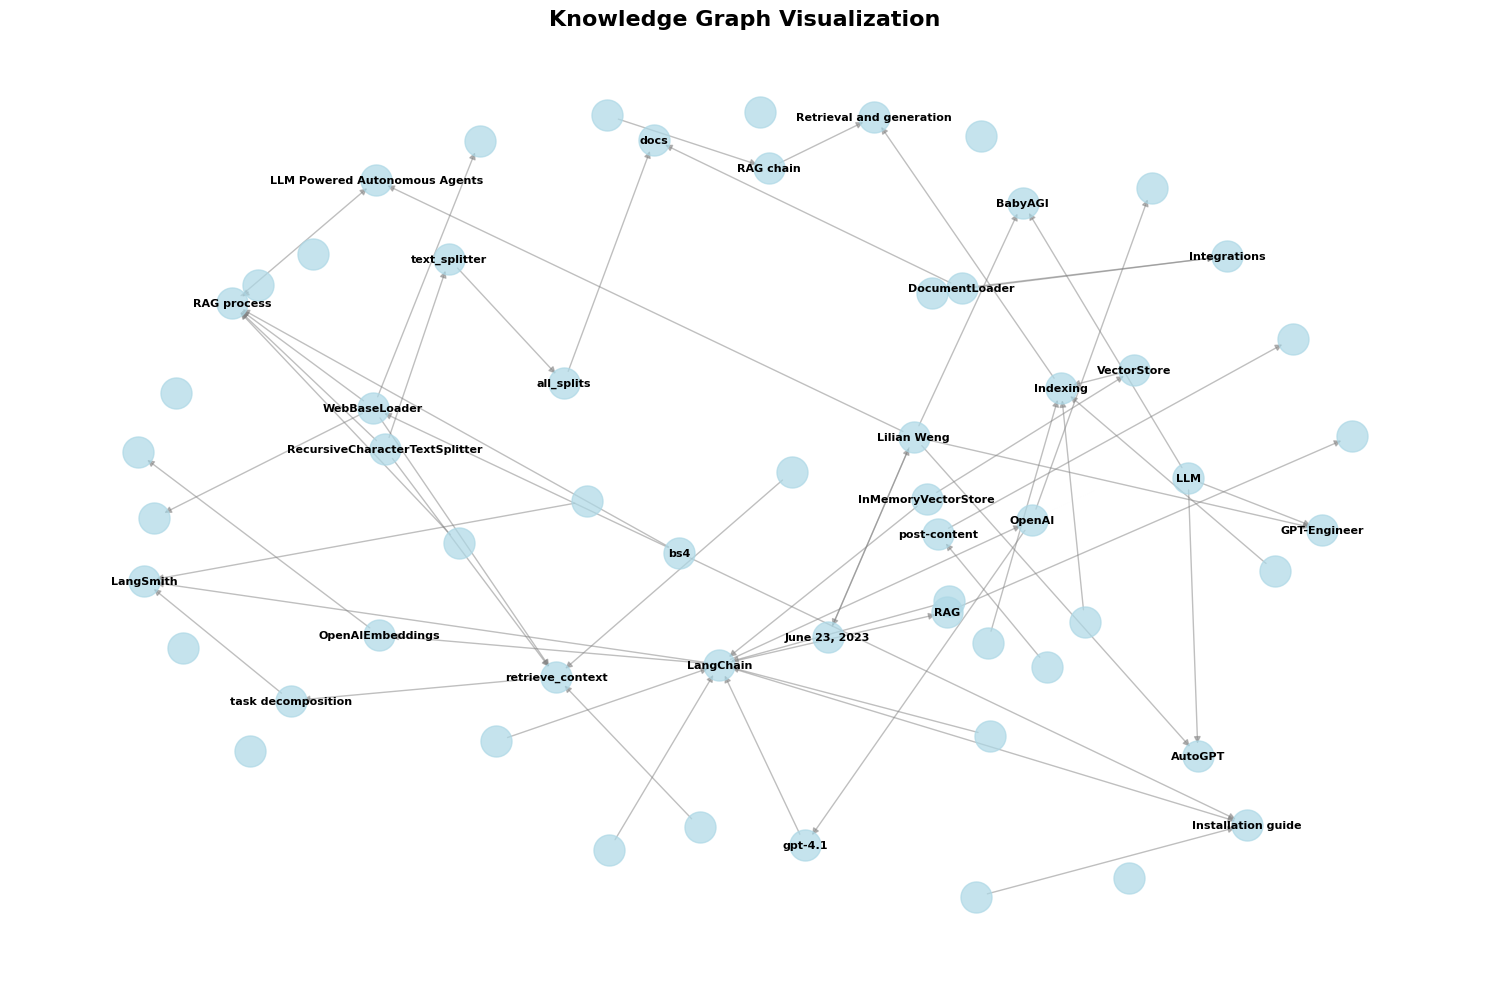


✓ Graph visualization complete

Note: Only high-degree nodes are labeled to reduce clutter


In [6]:
print_section_header("Visualizing Knowledge Graph")

# Create visualization
plt.figure(figsize=(15, 10))

# Use spring layout for better visualization
pos = nx.spring_layout(G, k=0.5, iterations=50)

# Draw nodes
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=500,
    node_color='lightblue',
    alpha=0.7,
)

# Draw edges
nx.draw_networkx_edges(
    G,
    pos,
    edge_color='gray',
    arrows=True,
    arrowsize=10,
    alpha=0.5,
)

# Draw labels (only for high-degree nodes to avoid clutter)
high_degree_nodes = [n for n, d in dict(G.degree).items() if d >= 2]
labels = {n: n for n in high_degree_nodes}
nx.draw_networkx_labels(
    G,
    pos,
    labels,
    font_size=8,
    font_weight='bold',
)

plt.title("Knowledge Graph Visualization", fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

print("\n✓ Graph visualization complete")
print("\nNote: Only high-degree nodes are labeled to reduce clutter")

## 7. Community Detection

Find clusters of related entities using the Louvain algorithm.

In [7]:
print_section_header("Community Detection")

# Convert to undirected for community detection
G_undirected = G.to_undirected()

# Louvain community detection
try:
    import community as community_louvain
    
    communities = community_louvain.best_partition(G_undirected)
    
    # Group nodes by community
    community_groups = defaultdict(list)
    for node, comm_id in communities.items():
        community_groups[comm_id].append(node)
    
    print(f"\n✓ Found {len(community_groups)} communities")
    
    # Show community sizes
    print("\nCommunity sizes:")
    for comm_id, members in sorted(community_groups.items(), key=lambda x: len(x[1]), reverse=True):
        print(f"  • Community {comm_id}: {len(members)} entities")
        print(f"    Sample members: {', '.join(members[:5])}")
    
except ImportError:
    print("\n⚠️  python-louvain not installed. Skipping community detection.")
    print("   Install with: pip install python-louvain")
    communities = {}
    community_groups = {}


COMMUNITY DETECTION


✓ Found 14 communities

Community sizes:
  • Community 0: 12 entities
    Sample members: LangChain, RAG, OpenAI, ChatGPT, Claude
  • Community 9: 10 entities
    Sample members: RAG process, LLM Powered Autonomous Agents, bs4, langchain, WebBaseLoader
  • Community 5: 9 entities
    Sample members: RAG agent, RAG chain, Indexing, Retrieval and generation, InMemoryVectorStore
  • Community 11: 7 entities
    Sample members: RecursiveCharacterTextSplitter, DocumentLoader, Integrations, BaseLoader, text_splitter
  • Community 10: 6 entities
    Sample members: LangSmith, vector_store, retrieve_context, create_agent, task decomposition
  • Community 7: 6 entities
    Sample members: Lilian Weng, June 23, 2023, LLM, AutoGPT, GPT-Engineer
  • Community 8: 3 entities
    Sample members: post-content, post-title, post-header
  • Community 12: 1 entities
    Sample members: Anthropic
  • Community 13: 1 entities
    Sample members: Azure
  • Community 1: 1 entities
    S

## 8. Create Graph Embeddings

Embed nodes for semantic search.

In [ ]:
print_section_header("Creating Graph Embeddings")

# Create documents for each entity
entity_docs = []

for node in G.nodes():
    node_data = G.nodes[node]
    entity_type = node_data.get('type', 'UNKNOWN')
    description = node_data.get('description', '')
    
    # Get connected entities
    neighbors = list(G.neighbors(node))
    neighbors_str = ", ".join(neighbors[:5]) if neighbors else "none"
    
    # Create document
    content = f"{node} ({entity_type}): {description}\nConnected to: {neighbors_str}"
    
    # Get degree for this node (type: int)
    node_degree: int = G.degree(node)  # type: ignore
    
    doc = Document(
        page_content=content,
        metadata={
            "entity_name": node,
            "entity_type": entity_type,
            "description": description,
            "degree": node_degree,
        },
    )
    entity_docs.append(doc)

print(f"\n✓ Created {len(entity_docs)} entity documents")

# Create vector store
embeddings = OpenAIEmbeddings(model=OPENAI_EMBEDDING_MODEL)
entity_store_path = VECTOR_STORE_DIR / "graphrag_entities"

entity_vectorstore = load_vector_store(entity_store_path, embeddings)

if entity_vectorstore is None:
    print("\nCreating entity vector store...")
    entity_vectorstore = FAISS.from_documents(entity_docs, embeddings)
    save_vector_store(entity_vectorstore, entity_store_path)
    print("✓ Entity vector store created")
else:
    print("✓ Loaded existing entity vector store")

# Create retriever
entity_retriever = entity_vectorstore.as_retriever(search_kwargs={"k": 5})
print("✓ Entity retriever ready")


CREATING GRAPH EMBEDDINGS


✓ Created 60 entity documents
✗ Error loading vector store from /Users/gianlucamazza/Workspace/notebooks/llm_rag/data/vector_stores/graphrag_entities: Error in faiss::FileIOReader::FileIOReader(const char *) at /Users/runner/work/faiss-wheels/faiss-wheels/third-party/faiss/faiss/impl/io.cpp:70: Error: 'f' failed: could not open /Users/gianlucamazza/Workspace/notebooks/llm_rag/data/vector_stores/graphrag_entities/index.faiss for reading: No such file or directory

Creating entity vector store...
✓ Saved vector store to /Users/gianlucamazza/Workspace/notebooks/llm_rag/data/vector_stores/graphrag_entities
✓ Entity vector store created
✓ Entity retriever ready


## 9. Implement Graph Traversal

Navigate the graph to find relevant subgraphs.

In [9]:
def get_subgraph(
    G: nx.DiGraph,
    start_nodes: List[str],
    max_hops: int = 2,
    max_nodes: int = 20,
) -> nx.Graph:
    """
    Extract subgraph around starting nodes.
    
    Args:
        G: Full knowledge graph
        start_nodes: Starting entities
        max_hops: Maximum distance to traverse
        max_nodes: Maximum nodes in subgraph
    
    Returns:
        Subgraph
    """
    subgraph_nodes = set()
    
    # BFS from each start node
    for start in start_nodes:
        if start not in G:
            continue
        
        # Get nodes within max_hops
        for node in nx.single_source_shortest_path_length(
            G.to_undirected(),
            start,
            cutoff=max_hops,
        ).keys():
            subgraph_nodes.add(node)
            
            if len(subgraph_nodes) >= max_nodes:
                break
        
        if len(subgraph_nodes) >= max_nodes:
            break
    
    # Create subgraph
    return G.subgraph(subgraph_nodes).copy()


def subgraph_to_text(subgraph: nx.DiGraph) -> str:
    """
    Convert subgraph to text representation.
    """
    lines = []
    
    lines.append(f"Entities ({len(subgraph.nodes())}):")
    for node in list(subgraph.nodes())[:15]:
        node_data = subgraph.nodes[node]
        entity_type = node_data.get('type', 'UNKNOWN')
        description = node_data.get('description', '')[:100]
        lines.append(f"  • {node} ({entity_type}): {description}")
    
    lines.append(f"\nRelationships ({len(subgraph.edges())}):")
    for source, target in list(subgraph.edges())[:15]:
        edge_data = subgraph.edges[source, target]
        relation = edge_data.get('relation', 'related_to')
        lines.append(f"  • {source} --[{relation}]--> {target}")
    
    return "\n".join(lines)


print("✓ Graph traversal functions defined")

✓ Graph traversal functions defined


## 10. Build GraphRAG Query Pipeline

## 9b. Test Entity Disambiguation

Demonstrate how to use entity disambiguation for queries.

In [ ]:
print_section_header("Testing Entity Disambiguation")

# Example: Disambiguate entities for a query
test_query = "What is LangChain?"

# Get all entity names
all_entity_names = [e.get('name') for e in all_entities if e.get('name')]
entities_list = "\n".join([f"- {name}" for name in all_entity_names[:20]])  # Show first 20

print(f"Query: {test_query}\n")
print("Disambiguating relevant entities...")

# Use disambiguation prompt
disambiguation_chain = ENTITY_DISAMBIGUATION_PROMPT | llm | StrOutputParser()
relevant_entities_text = disambiguation_chain.invoke({
    "query": test_query,
    "entities": entities_list,
})

print("\nRelevant entities identified:")
print(relevant_entities_text)

print("\n✓ Entity disambiguation helps focus on query-relevant entities")

In [10]:
def graphrag_query(
    question: str,
    G: nx.DiGraph,
    entity_retriever,
    llm,
    max_hops: int = 2,
    use_summarization: bool = True,
    verbose: bool = False,
) -> Dict[str, Any]:
    """
    GraphRAG query pipeline.
    
    Args:
        question: User question
        G: Knowledge graph
        entity_retriever: Entity retriever
        llm: Language model
        max_hops: Maximum graph traversal hops
        use_summarization: Use graph summarization for context
        verbose: Print debug info
    
    Returns:
        Query results
    """
    if verbose:
        print(f"\n[GraphRAG] Question: {question}")
    
    # 1. Retrieve relevant entities
    relevant_docs = entity_retriever.invoke(question)
    start_entities = [doc.metadata["entity_name"] for doc in relevant_docs]
    
    if verbose:
        print(f"[GraphRAG] Start entities: {', '.join(start_entities[:5])}")
    
    # 2. Extract subgraph
    subgraph = get_subgraph(G, start_entities, max_hops=max_hops)
    
    if verbose:
        print(f"[GraphRAG] Subgraph: {len(subgraph.nodes())} nodes, {len(subgraph.edges())} edges")
    
    # 3. Convert to text or summarize
    subgraph_text = subgraph_to_text(subgraph)
    
    if use_summarization and len(subgraph.nodes()) > 10:
        # Use summarization for larger subgraphs
        if verbose:
            print("[GraphRAG] Using graph summarization...")
        
        summary_chain = GRAPH_SUMMARIZATION_PROMPT | llm | StrOutputParser()
        context = summary_chain.invoke({"subgraph": subgraph_text})
        
        if verbose:
            print(f"[GraphRAG] Summarized context length: {len(context)} chars")
    else:
        context = subgraph_text
    
    # 4. Generate answer
    answer_chain = GRAPHRAG_ANSWER_PROMPT | llm | StrOutputParser()
    answer = answer_chain.invoke({
        "input": question,
        "context": context,
        "query_entities": ", ".join(start_entities[:5]),
        "num_hops": max_hops,
        "num_nodes": len(subgraph.nodes()),
    })
    
    return {
        "question": question,
        "start_entities": start_entities,
        "subgraph": subgraph,
        "context": context,
        "answer": answer,
        "used_summarization": use_summarization and len(subgraph.nodes()) > 10,
    }


print("✓ GraphRAG query pipeline defined")
print("✓ Pipeline now supports graph summarization for large subgraphs")

✓ GraphRAG query pipeline defined


## 11. Test GraphRAG

In [11]:
print_section_header("Testing GraphRAG")

test_questions = [
    "What is LangChain and what are its main components?",
    "How do chains work in LangChain?",
    "What role do retrievers play in RAG applications?",
]

for i, question in enumerate(test_questions, 1):
    print("\n" + "=" * 80)
    print(f"Question {i}: {question}")
    print("=" * 80)
    
    result = graphrag_query(
        question=question,
        G=G,
        entity_retriever=entity_retriever,
        llm=llm,
        max_hops=2,
        verbose=True,
    )
    
    print("\n" + "-" * 80)
    print("ANSWER:")
    print("-" * 80)
    print(result["answer"])


TESTING GRAPHRAG


Question 1: What is LangChain and what are its main components?

[GraphRAG] Question: What is LangChain and what are its main components?
[GraphRAG] Start entities: LangChain, LangGraph, LangSmith, Cursor, VS Code
[GraphRAG] Subgraph: 20 nodes, 20 edges

--------------------------------------------------------------------------------
ANSWER:
--------------------------------------------------------------------------------
LangChain is a suite of integrations designed for building applications with language models. It serves as a framework that facilitates the development of applications that leverage various AI models and technologies.

The main components of LangChain include:

1. **LangGraph**: A component that supports various integrations and functionalities within LangChain.
2. **RAG (Retrieval Augmented Generation)**: A technique used for sophisticated question-answering applications, which is integrated into LangChain.
3. **OpenAIEmbeddings**: A class for gene

## 11b. Compare with/without Summarization

Test the difference between raw subgraph and summarized context.

In [ ]:
print_section_header("Comparing Summarization Impact")

test_query = "What is LangChain and how does it work?"

print(f"Query: {test_query}\n")
print("=" * 80)

# Without summarization
print("\n[WITHOUT SUMMARIZATION]")
print("-" * 80)
result_no_sum = graphrag_query(
    question=test_query,
    G=G,
    entity_retriever=entity_retriever,
    llm=llm,
    max_hops=2,
    use_summarization=False,
    verbose=True,
)
print(f"\nContext length: {len(result_no_sum['context'])} chars")

# With summarization
print("\n" + "=" * 80)
print("\n[WITH SUMMARIZATION]")
print("-" * 80)
result_with_sum = graphrag_query(
    question=test_query,
    G=G,
    entity_retriever=entity_retriever,
    llm=llm,
    max_hops=2,
    use_summarization=True,
    verbose=True,
)
print(f"\nContext length: {len(result_with_sum['context'])} chars")
print(f"Used summarization: {result_with_sum['used_summarization']}")

# Compare
print("\n" + "=" * 80)
print("COMPARISON:")
print("=" * 80)
print(f"Without summarization: {len(result_no_sum['context'])} chars")
print(f"With summarization: {len(result_with_sum['context'])} chars")
if result_with_sum['used_summarization']:
    reduction = (1 - len(result_with_sum['context']) / len(result_no_sum['context'])) * 100
    print(f"Context reduction: {reduction:.1f}%")
    print("\n✅ Summarization helps compress large subgraphs while preserving key information")
else:
    print("\n⚠️  Subgraph too small for summarization (< 10 nodes)")

## 12. Visualize Query Subgraph


VISUALIZING QUERY SUBGRAPH



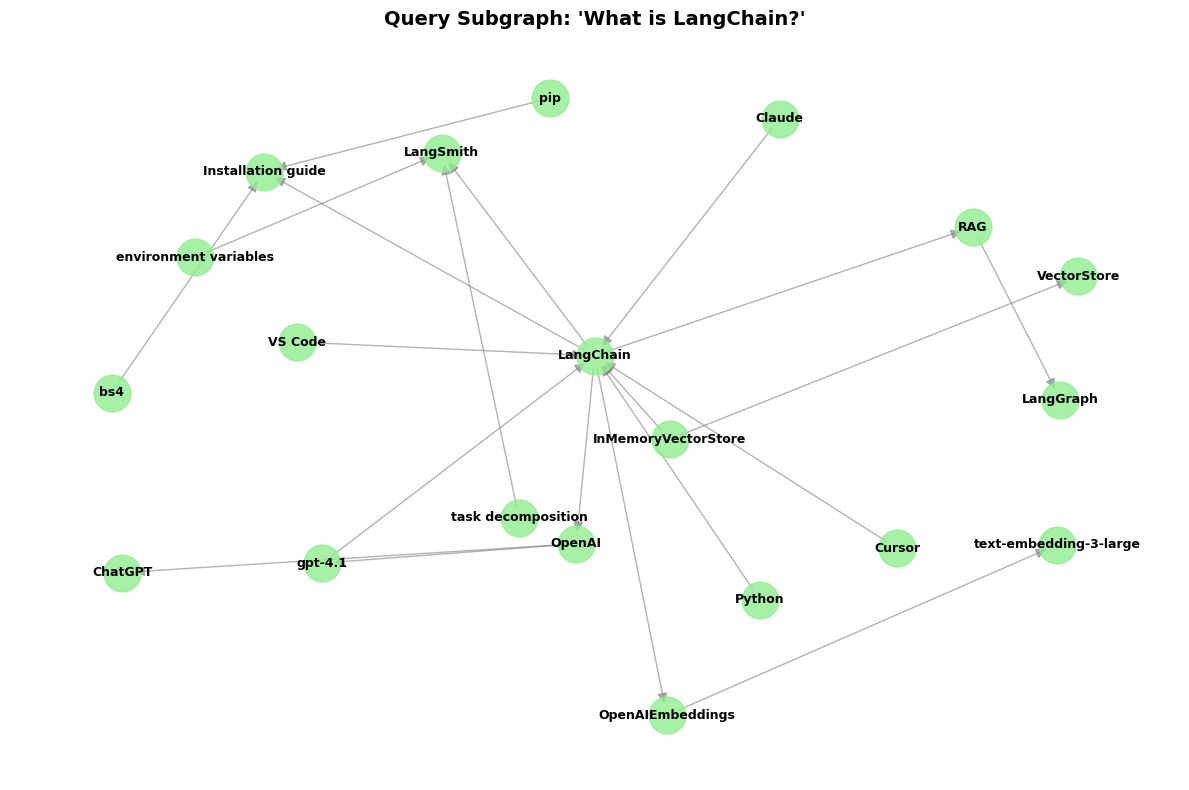


✓ Subgraph for query: 'What is LangChain?'
  • Nodes: 20
  • Edges: 20


In [12]:
print_section_header("Visualizing Query Subgraph")

# Get subgraph for a query
query = "What is LangChain?"
result = graphrag_query(
    question=query,
    G=G,
    entity_retriever=entity_retriever,
    llm=llm,
    verbose=False,
)

subgraph = result["subgraph"]

# Visualize
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, k=1, iterations=50)

# Draw
nx.draw_networkx_nodes(subgraph, pos, node_size=700, node_color='lightgreen', alpha=0.8)
nx.draw_networkx_edges(subgraph, pos, edge_color='gray', arrows=True, arrowsize=15, alpha=0.6)
nx.draw_networkx_labels(subgraph, pos, font_size=9, font_weight='bold')

plt.title(f"Query Subgraph: '{query}'", fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\n✓ Subgraph for query: '{query}'")
print(f"  • Nodes: {len(subgraph.nodes())}")
print(f"  • Edges: {len(subgraph.edges())}")

## 13. Comparison: GraphRAG vs Vector RAG

In [13]:
# Build simple vector RAG for comparison
from shared.prompts import RAG_PROMPT_TEMPLATE
from shared.utils import format_docs
from langchain_core.runnables import RunnablePassthrough

print_section_header("GraphRAG vs Vector RAG Comparison")

# Load vector store
vector_store_path = VECTOR_STORE_DIR / "graphrag_comparison"
vectorstore = load_vector_store(vector_store_path, embeddings)

if vectorstore is None:
    vectorstore = FAISS.from_documents(docs_sample, embeddings)
    save_vector_store(vectorstore, vector_store_path)

vector_retriever = vectorstore.as_retriever(search_kwargs={"k": 4})

# Build vector RAG chain
vector_rag_chain = (
    {"context": vector_retriever | format_docs, "input": RunnablePassthrough()}
    | RAG_PROMPT_TEMPLATE
    | llm
    | StrOutputParser()
)

# Test query
test_query = "What are the relationships between LangChain components?"

print(f"\nQuery: {test_query}\n")
print("=" * 80)

# Vector RAG
print("\n[VECTOR RAG]")
print("-" * 80)
vector_answer = vector_rag_chain.invoke(test_query)
print(vector_answer)

# GraphRAG
print("\n" + "=" * 80)
print("\n[GRAPHRAG]")
print("-" * 80)
graph_result = graphrag_query(
    question=test_query,
    G=G,
    entity_retriever=entity_retriever,
    llm=llm,
    verbose=False,
)
print(graph_result["answer"])

# Comparison
print("\n" + "=" * 80)
print("ANALYSIS:")
print("=" * 80)
print("Vector RAG:")
print("  • Finds semantically similar documents")
print("  • Fast retrieval")
print("  • May miss relationship context")
print("\nGraphRAG:")
print("  • Understands entity relationships")
print("  • Multi-hop reasoning")
print("  • Explicit connection paths")
print("  • Better for 'how are X and Y related' queries")


GRAPHRAG VS VECTOR RAG COMPARISON

✗ Error loading vector store from /Users/gianlucamazza/Workspace/notebooks/llm_rag/data/vector_stores/graphrag_comparison: Error in faiss::FileIOReader::FileIOReader(const char *) at /Users/runner/work/faiss-wheels/faiss-wheels/third-party/faiss/faiss/impl/io.cpp:70: Error: 'f' failed: could not open /Users/gianlucamazza/Workspace/notebooks/llm_rag/data/vector_stores/graphrag_comparison/index.faiss for reading: No such file or directory
✓ Saved vector store to /Users/gianlucamazza/Workspace/notebooks/llm_rag/data/vector_stores/graphrag_comparison

Query: What are the relationships between LangChain components?


[VECTOR RAG]
--------------------------------------------------------------------------------
✓ Saved vector store to /Users/gianlucamazza/Workspace/notebooks/llm_rag/data/vector_stores/graphrag_comparison

Query: What are the relationships between LangChain components?


[VECTOR RAG]
----------------------------------------------------------

## 14. Key Takeaways

### Summary

**GraphRAG** represents a paradigm shift from vectors to graphs:
- Entities and relationships as first-class citizens
- Multi-hop reasoning through graph traversal
- Community-based summarization
- Explainable reasoning paths

### Pipeline Recap

1. **Entity Extraction**: LLM identifies entities (⏱️ slow)
2. **Relationship Extraction**: LLM finds connections (⏱️ slow)
3. **Graph Construction**: Build NetworkX graph (✅ fast)
4. **Community Detection**: Cluster related entities (✅ fast)
5. **Graph Embeddings**: Index for search (✅ fast)
6. **Query Processing**: Find relevant entities (✅ fast)
7. **Graph Traversal**: Extract subgraph (✅ fast)
8. **Answer Generation**: LLM synthesizes (⏱️ medium)

### Cost Analysis

| Phase | Cost | Notes |
|-------|------|-------|
| **Indexing** | ❌ Very High | 2N LLM calls (N docs) |
| Entity extraction | High | 1 call per doc |
| Relationship extraction | High | 1 call per doc |
| Graph construction | Low | Local computation |
| **Querying** | ✅ Low | 1-2 LLM calls |
| Entity retrieval | Low | Vector search |
| Graph traversal | Low | NetworkX operations |
| Answer generation | Medium | 1 LLM call |

### Best Practices

**Entity Extraction:**
- ✅ Use structured output (JSON)
- ✅ Consistent entity types
- ✅ Disambiguate similar entities
- ✅ Merge duplicate entities

**Relationship Extraction:**
- ✅ Use semantic relation types
- ✅ Validate both endpoints exist
- ✅ Add confidence scores
- ✅ Include descriptions

**Graph Management:**
- ✅ Limit subgraph size
- ✅ Use efficient traversal algorithms
- ✅ Cache common subgraphs
- ✅ Persist graph to database (Neo4j, etc.)

**Query Optimization:**
- ✅ Start from high-degree nodes
- ✅ Limit max hops (2-3)
- ✅ Prune irrelevant branches
- ✅ Use community summaries for global queries

### GraphRAG vs Vector RAG

| Aspect | Vector RAG | GraphRAG |
|--------|------------|----------|
| **Indexing Time** | ✅ Fast | ❌ Very Slow |
| **Indexing Cost** | ✅ Low | ❌ Very High |
| **Query Time** | ✅ Fast | ✅ Fast |
| **Storage** | ✅ Efficient | ❌ Higher |
| **Simple Queries** | ✅ Excellent | ⚠️ Overkill |
| **Multi-hop** | ❌ Poor | ✅ Excellent |
| **Relationships** | ❌ Implicit | ✅ Explicit |
| **Explainability** | ⚠️ Medium | ✅ High |

### When to Use GraphRAG

Choose **GraphRAG** when:
- ✅ Relationships are first-class citizens
- ✅ Multi-hop reasoning is needed
- ✅ Indexing cost is acceptable (one-time)
- ✅ Explainability is important
- ✅ Entity-centric queries
- ✅ Complex knowledge domains

Stick with **Vector RAG** when:
- ✅ Simple document retrieval
- ✅ Fast indexing required
- ✅ Cost-sensitive
- ✅ Relationships aren't critical
- ✅ Semantic similarity is enough

### Production Considerations

**Scale:**
- Use graph databases (Neo4j, Amazon Neptune)
- Batch entity/relationship extraction
- Implement incremental updates
- Cache frequently accessed subgraphs

**Quality:**
- Manual entity review
- Confidence scoring
- Entity merging/deduplication
- Relationship validation

**Performance:**
- Pre-compute common subgraphs
- Index graph properties
- Use graph algorithms (PageRank, etc.)
- Optimize traversal paths

### Extensions

**Advanced Features:**
- Temporal graphs (time-aware relationships)
- Probabilistic edges (confidence scores)
- Multi-modal graphs (text + images + code)
- Dynamic graph updates
- Graph neural networks (GNNs)

**Microsoft GraphRAG Features:**
- Global vs Local queries
- Hierarchical communities
- Community summaries
- Map-Reduce over communities

---

**Complexity Rating:** ⭐⭐⭐⭐⭐ (Very High - most complex RAG architecture)

**Production Readiness:** ⭐⭐ (Experimental - requires significant investment)

**Best For:** Research, knowledge-intensive applications, when relationships matter more than documents

Continue to **16_evaluation_ragas.ipynb** for comprehensive RAG evaluation!

## Enhanced Features Summary

This notebook now includes all advanced GraphRAG features:

### 1. **Entity Disambiguation** (Section 3b)
- Deduplicates entities with similar names
- Reduces redundancy in the knowledge graph
- Uses `ENTITY_DISAMBIGUATION_PROMPT` for query-based filtering

### 2. **Graph Summarization** (Section 10, 11b)
- Automatically summarizes large subgraphs (>10 nodes)
- Uses `GRAPH_SUMMARIZATION_PROMPT` for context compression
- Reduces LLM context size while preserving key information
- Configurable via `use_summarization` parameter

### 3. **Consistent Configuration**
- Uses `DEFAULT_TEMPERATURE` from config for reproducible results
- All LLM calls now use shared configuration

### Improvements:
✅ **Better deduplication**: Cleaner knowledge graph
✅ **Scalable context**: Handles larger subgraphs efficiently  
✅ **Flexible querying**: Choose raw or summarized context
✅ **Consistent behavior**: Uses centralized config

---
